# Practica 2

In [34]:
import nltk
import pickle
import numpy as np
import pandas as pd
from unidecode import unidecode
from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
#nltk.download('punkt')
%matplotlib inline

In [3]:
with open('corpusML.txt', 'r') as f:
    corpus = f.readlines()

In [4]:
corpus = [unidecode(line.lower()) for line in corpus]

In [5]:
corpus[0:2]

['comence a trabajar y me pegaron, me maltrataron con chicote \n',
 'mis patrones me pegaron porque no me queria apurar, porque era flojo \n']

### 1, 2) Limpiar corpus y agregar simbolos de inicio y fin

* Se limpia el corpus mediante el algoritmo de Porter para el lenguaje español. 
* A cada oracion del corpus, se le agrega el simbolo de inicio y fin. 
* Se crea el alfabeto $\Sigma$ del corpus donde se almacenen unicamente los tipos 

In [6]:
stemmer = SnowballStemmer("spanish")
stems = []                                              # Lista de stems por cada oracion
cleanedCorpus = []                                      # Corpus procesado con stemming
Sigma = []                                              # Alfabeto del corpus (tipos)               

for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)               # Obtener lista tokens
    for tk in tokens:   
        if tk.isalpha():                                # Validar token como caracter del alfabeto                                
            stem = stemmer.stem(tk)                     # Aplicar algotimo de stemming
            stems.append(stem)                          
            if stem not in Sigma:                      
                Sigma.append(stem)
    s = '<BOS> ' + ' '.join(stems) + ' <EOS>'           # Agregar simbolos de inicio y fin
    cleanedCorpus.append(s)                             # Agregar oracion procesada a la lista del corpus limpio                               
    stems.clear()

# Agregar simbolos de inicio y fin al alfabeto
Sigma.append('<BOS>')
Sigma.append('<EOS>')

In [7]:
cleanedCorpus[:3]

['<BOS> comenc a trabaj y me peg me maltrat con chicot <EOS>',
 '<BOS> mis patron me peg porqu no me queri apur porqu era floj <EOS>',
 '<BOS> por eso me habi peg <EOS>']

In [8]:
Sigma[-10:]

['cab',
 'bebecit',
 'tabiqu',
 'calent',
 'pajuel',
 'vapor',
 'quemart',
 'cai',
 '<BOS>',
 '<EOS>']

### 3) Obtener los bigramas

In [9]:
def bigrams(sequence):
    s = sequence.split()
    return [(wi, wj) for wi, wj in zip(s[:-1], s[1:])]

In [10]:
# Obtener los bigramas del corpus limpio
sentence_bigrams = [bigrams(s) for s in cleanedCorpus]

In [11]:
sentence_bigrams[0]

[('<BOS>', 'comenc'),
 ('comenc', 'a'),
 ('a', 'trabaj'),
 ('trabaj', 'y'),
 ('y', 'me'),
 ('me', 'peg'),
 ('peg', 'me'),
 ('me', 'maltrat'),
 ('maltrat', 'con'),
 ('con', 'chicot'),
 ('chicot', '<EOS>')]

In [12]:
# Bigramas de todo el corpus
corpus_bigrams = [bigram for sentence in sentence_bigrams for bigram in sentence]

In [13]:
# Obtener los vectores one hot de cada palabra en el corpus
oneHotMatrix = np.identity(len(Sigma))

In [14]:
word2oneHot = {}        # Entrada: palabra del alfabeto, Salida: vector one hot
word2number = {}        # Entrada: palabra del alfabeto, Salida: indice en la lista del alfabeto
oneHot2word = {}        # Entrada: vector one hot (caracteres), Salida: palabra del alfabeto

for i, (word, vector) in enumerate(zip(Sigma, oneHotMatrix)):
    word2oneHot[word] = vector
    word2number[word] = i
    oneHot2word[np.where(vector==1)[0][0]] = word

In [15]:
word2oneHot['<EOS>']

array([0., 0., 0., ..., 0., 0., 1.])

In [16]:
word2number['<EOS>']

1215

### 4) Entrenar la red neuronal con los bigramas

Dados los bigramas del corpus $(w_i, w_j)$, la red neuronal word2vec es entrenada tomando como entrada y salida a la representacion vectorial *one hot encoded* de la palabra $w_i$ y la palabra $w_j$ respectivamente.

In [17]:
class word2vec():
    def __init__(self, d, N, weights):
        if weights:
            self.U = weights[0]
            self.W = weights[1]
        else:
            self.U = np.random.randn(d, N)*np.sqrt(1/(d+N)) 
            self.W = np.random.randn(N, d)*np.sqrt(1/(d+N)) 
            
    def softmax(self, x):
        exp = np.exp(x-np.max(x))
        return np.divide(exp, np.sum(exp))
    
    def predict(self, x):
        h = np.dot(self.U, x)
        a = np.dot(self.W, h)
        return self.softmax(a)
    
    def fit(self, bigrams, lr, epochs):
        lossWi = []
        loss = []
        for epoch in range(epochs):
            for k, (wi, wj) in enumerate(bigrams):
                x = word2oneHot[wi]
                y = word2oneHot[wj]
                # Feedforward
                h = self.U[:, np.where(x==1)[0][0]]
                a = self.softmax(np.dot(self.W, h))
                # Calcular error
                error = a - y
                # ---- Calcular funcion de perdida ----
                lossWi.append(np.log(a[np.where(y==1)[0][0]]+0.0000000000001))
                if k == len(bigrams)-1:
                    loss.append(-np.sum(lossWi))
                    lossWi.clear()
                    print('EPOCH ({}) = {}'.format(epoch+1, loss[epoch]))
                # -------------------------------------
                # Backpropragation
                dW = np.outer(error, h)
                self.W -= lr*dW
                dU = np.dot(self.W.T, error)
                self.U[:, np.where(x==1)[0][0]] -= lr*dU
        return loss

In [18]:
w2v = word2vec(300, len(Sigma), None)

In [21]:
%%time
err = w2v.fit(corpus_bigrams, 0.004, 100)

EPOCH (1) = 88540.04035694257
EPOCH (2) = 87563.2395231307
EPOCH (3) = 85111.47455143604
EPOCH (4) = 83063.44945773488
EPOCH (5) = 80943.28931752767
EPOCH (6) = 78631.31894757965
EPOCH (7) = 76164.09006487996
EPOCH (8) = 73772.8260329155
EPOCH (9) = 71637.66750051823
EPOCH (10) = 69803.9779112821
EPOCH (11) = 68252.69795043182
EPOCH (12) = 66891.89634484766
EPOCH (13) = 65674.03854017355
EPOCH (14) = 64569.41958924678
EPOCH (15) = 63552.084920478475
EPOCH (16) = 62610.031046847726
EPOCH (17) = 61738.07517302538
EPOCH (18) = 60933.52796945114
EPOCH (19) = 60194.06805261693
EPOCH (20) = 59517.35653043348
EPOCH (21) = 58897.53361616776
EPOCH (22) = 58326.577365012505
EPOCH (23) = 57797.81488775553
EPOCH (24) = 57305.30139870303
EPOCH (25) = 56843.27896565282
EPOCH (26) = 56406.647550456546
EPOCH (27) = 55991.20453314094
EPOCH (28) = 55593.6766307463
EPOCH (29) = 55211.64263495792
EPOCH (30) = 54843.365883700906
EPOCH (31) = 54487.65610773818
EPOCH (32) = 54143.776215006605
EPOCH (33) = 53

In [28]:
# Guardar parametros de la red
with open('weights.pickle', 'wb') as file:
    pickle.dump([w2v.U, w2v.W, err], file)

In [29]:
# Leer el archivo con los parametros
# y cargarlos en la red neuronal
with open('weights.pickle', 'rb') as file:
    U, W, err = pickle.load(file)
    
w2v.U = U
w2v.W = W

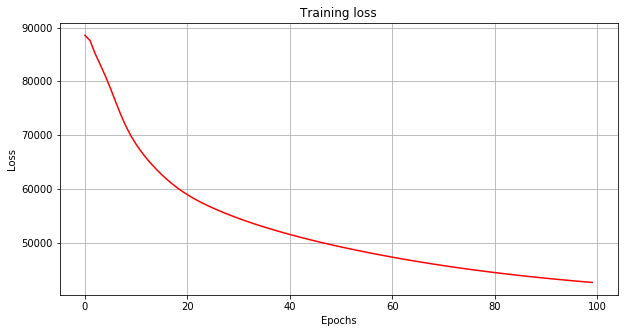

In [31]:
plt.figure(figsize=(10,5))
plt.title('Training loss')
plt.plot(err, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [32]:
# Prueba de prediccion
word = 'las'
wordVector = word2oneHot[stemmer.stem(word)]
pred = w2v.predict(wordVector)
print('Suma = ', np.sum(pred))                    # Suma para verificar que sea igual a 1
indice = np.argmax(pred)                          # Indice de la palabra con mayor probilidad
word_predicted = oneHot2word[indice] 

print('Indice palabra pred = ', indice)
print('Prediccion = ', word_predicted)
print('P({}|{}) = {}'.format(word_predicted, word, pred[indice]))
print(word + ' ' + word_predicted)

Suma =  1.0
Indice palabra pred =  290
Prediccion =  vac
P(vac|las) = 0.09013204336800337
las vac


### 5) Obtener las matrices $A$ y $\Pi$

In [43]:
# Para cada palabra del alfabeto, predecir el vector de probabilidades
# y agruparlos por columna para hacer la matriz A

A = []

for wj in Sigma[:-2]:
    aj = w2v.predict(word2oneHot[wj])
    A.append(list(aj))
    
A = np.matrix(A).T

In [54]:
AFrame = pd.DataFrame(A, columns=Sigma[:-2], index=Sigma)
AFrame.head()

,comenc,a,trabaj,y,me,peg,maltrat,con,chicot,mis,...,juguetit,entram,cab,bebecit,tabiqu,calent,pajuel,vapor,quemart,cai
comenc,0.000032,2.880960e-06,0.000092,2.581549e-05,9.299326e-06,0.000005,0.000019,2.828900e-05,0.000016,0.000041,...,0.000731,0.000260,0.000120,0.000522,0.000065,0.000068,0.000098,0.000006,0.000015,0.000032
a,0.912658,1.174837e-09,0.033035,3.478904e-02,2.077814e-09,0.116945,0.007806,8.156137e-08,0.000477,0.000336,...,0.003290,0.021974,0.006418,0.004598,0.000477,0.002899,0.022380,0.000290,0.000551,0.912625
trabaj,0.000088,4.718075e-02,0.000317,5.581653e-03,1.502328e-06,0.000213,0.000144,4.202898e-02,0.000049,0.000006,...,0.001253,0.000991,0.000360,0.002255,0.000671,0.000596,0.000504,0.000025,0.000053,0.000106
y,0.002019,6.101583e-11,0.062608,1.816087e-07,1.843201e-08,0.000878,0.006926,6.277016e-08,0.002398,0.000059,...,0.003740,0.006792,0.007608,0.007512,0.000906,0.005302,0.009901,0.001555,0.002011,0.001635
me,0.000828,1.217324e-10,0.002654,2.875440e-02,1.104432e-08,0.019035,0.000599,3.971293e-07,0.000225,0.000021,...,0.001449,0.002892,0.001612,0.005527,0.000561,0.000879,0.001897,0.000123,0.000228,0.000625


In [47]:
# El vector de inicio se obtiene al predecir la distribucion
# para el simbolo <BOS>
Pi = w2v.predict(word2oneHot['<BOS>'])

In [53]:
PiFrame = pd.DataFrame(Pi, columns=['<BOS>'], index=Sigma)
PiFrame.head()

,<BOS>
comenc,0.000718
a,0.004623
trabaj,0.000928
y,0.026370
me,0.003424


### 6) Calcular la propabilidad de las siguientes oraciones

Se calcularan usando la propiedad de Markov que establece que:

$p(x_1,...,x_n)=\prod_{i=1}^{n}p(w_{i}|w_{i-1})$

In [99]:
def probSentence(sentence):
    s = unidecode(sentence.lower()).split()
    s = [stemmer.stem(word) for word in s]
    s.insert(0, '<BOS>')
    p = 1
    for wi, wj in zip(s[:-1], s[1:]):
        if wi == '<BOS>':
            p *= Pi[word2number[wj]]
            print("p({}|<BOS>) = {}".format(wj, Pi[word2number[wj]]))
        else:
            i = word2number[wj]
            j = word2number[wi]
            p *= A[i,j]
            print("p({}|{}) = {}".format(wj, wi, A[i,j]))
    return p

__1)__ Nos bañamos con agua caliente

$p(caliente|agua)p(agua|con)p(con|banamos)p(banamos|nos)p(nos|BOS)$

In [100]:
s = 'Nos bañamos con agua caliente'
p = probSentence(s)
print("\np({}) = {}".format(s, p))

p(nos|<BOS>) = 0.004946974480739738
p(ban|nos) = 0.10085018507136384
p(con|ban) = 0.0901471634684893
p(agu|con) = 0.008242887789336078


KeyError: 'calient'

__2)__ El animalito le olía la cabeza

$p(cabeza|la)p(la|olía)p(olía|le)p(le|animalito)p(animalito|El)p(El|BOS)$

In [95]:
s = 'El animalito le olía la cabeza'
p = probSentence(s)
print("\np({}) = {}".format(s, p))

p(el|<BOS>) = 0.015374957497752403
p(animalit|el) = 0.00730314829103099
p(le|animalit) = 0.00021801136616107037
p(oli|le) = 0.0073855543913399335
p(la|oli) = 0.7661320513412359
p(cabez|la) = 0.016043672648553407

p(El animalito le olía la cabeza) = 2.2222540379070525e-12


__3)__ Pascuala ordeñaba las vacas

$p(vacas|las)p(las|ordeñaba)p(ordeñaba|Pascuala)p(Pascuala|BOS)$

In [94]:
s = 'Pascuala ordenaba las vacas'
p = probSentence(s)
print("\np({}) = {}".format(s, p))

p(pascual|<BOS>) = 3.067391209926182e-07
p(orden|pascual) = 0.0001250090492969274
p(las|orden) = 0.22236818056456176
p(vac|las) = 0.048166136866796855

p(Pascuala ordenaba las vacas) = 4.107003558158592e-13
